<a href="https://colab.research.google.com/github/acewolfag/modelFaceNet/blob/main/FaceNet_PyTourch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [11]:
# IMPORTANT: SOME KAGGLE DATA SOURCES ARE PRIVATE
# RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES.
import kagglehub
kagglehub.login()


In [12]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

dansbecker_5_celebrity_faces_dataset_path = kagglehub.dataset_download('dansbecker/5-celebrity-faces-dataset')
timesler_facenet_pytorch_vggface2_path = kagglehub.dataset_download('timesler/facenet-pytorch-vggface2')
acewolfag_facenet_dataset_path = kagglehub.dataset_download('acewolfag/facenet-dataset')

print('Data source import complete.')


Data source import complete.


# Face Recognition using Facenet and SVM with PCA Visualization

The provided code implements a face recognition system using the [facenet-pytorch](https://www.kaggle.com/datasets/timesler/facenet-pytorch-vggface2) library and training using SVM Model. Here's a summary of the code:

1. Installation: The code installs the facenet-pytorch library from a local file using pip.
2. Model Checkpoints: The code copies the model checkpoints to the torch cache directory for automatic loading during runtime.
3. Importing Required Libraries: Necessary libraries and modules are imported for various functionalities, including image processing, machine learning, face detection, and feature extraction.
4. Helper Functions: Two helper functions are defined. The whitens function normalizes an input image tensor, and the extract_features function detects faces in an image and extracts their feature embeddings.
5. Device Configuration: The code sets the device to either GPU or CPU based on availability.
6. Model Initialization: The MTCNN and Inception ResNet V1 models are initialized with pre-trained weights. The models are moved to the selected device.
7. Dataset Preparation: The code defines the path to the dataset folder and creates ImageFolder datasets for the training and validation sets.
8. Embedding Extraction: The dataset_to_embeddings function is called to extract face embeddings from the training and validation sets.
9. Model Training: The train function is called to train the face recognition model using the extracted embeddings.
10. Model Saving: The trained model is serialized and saved as a pickle file.
11. Model Evaluation: The code generates a classification report and calculates the accuracy of the trained model using the embeddings from the training set.
12. Visualization: The code uses PCA to reduce the dimensionality of the embeddings and plots a 2D scatter plot of the embeddings with different colors representing different labels.
13. Image Testing: Random images from the validation set are selected and their predicted labels are compared with the true labels. The images, along with the predicted and actual labels, are displayed.
14. Single Image Testing: A single image is tested for face recognition, and the predicted label is displayed along with the image.

## Importing Required Libraries

The necessary libraries and modules are imported, including:

In [13]:
import os
import shutil
from sklearn.model_selection import train_test_split
path_folder = "/root/.cache/kagglehub/datasets/acewolfag/facenet-dataset/versions/1/Original Images"
# Đường dẫn gốc đến thư mục chứa dữ liệu
source_folder = "/root/.cache/kagglehub/datasets/acewolfag/facenet-dataset/versions/1/Original Images"
train_folder = "/content/train"
val_folder = "/content/val"

# Tạo thư mục train và val nếu chưa có
os.makedirs(train_folder, exist_ok=True)
os.makedirs(val_folder, exist_ok=True)

# Lặp qua tất cả các folder (tương ứng với từng class)
for person in os.listdir(source_folder):
    person_path = os.path.join(source_folder, person)

    # Kiểm tra nếu đó là một folder
    if os.path.isdir(person_path):
        # Lấy danh sách các file trong folder person
        images = os.listdir(person_path)

        # Chia dữ liệu theo tỷ lệ train và val
        train_images, val_images = train_test_split(images, test_size=0.2, random_state=42)

        # Tạo thư mục cho class trong train và val
        train_class_folder = os.path.join(train_folder, person)
        val_class_folder = os.path.join(val_folder, person)
        os.makedirs(train_class_folder, exist_ok=True)
        os.makedirs(val_class_folder, exist_ok=True)

        # Di chuyển file vào thư mục tương ứng
        for image in train_images:
            shutil.copy(os.path.join(person_path, image), os.path.join(train_class_folder, image))

        for image in val_images:
            shutil.copy(os.path.join(person_path, image), os.path.join(val_class_folder, image))

        print(f"Đã hoàn thành phân chia cho class {person}")

print("Đã hoàn tất phân chia dữ liệu!")


Đã hoàn thành phân chia cho class Claire Holt
Đã hoàn thành phân chia cho class Zac Efron
Đã hoàn thành phân chia cho class Marmik
Đã hoàn thành phân chia cho class Akshay Kumar
Đã hoàn thành phân chia cho class Virat Kohli
Đã hoàn thành phân chia cho class Alexandra Daddario
Đã hoàn thành phân chia cho class Hrithik Roshan
Đã hoàn thành phân chia cho class Andy Samberg
Đã hoàn thành phân chia cho class Billie Eilish
Đã hoàn thành phân chia cho class Hugh Jackman
Đã hoàn thành phân chia cho class Roger Federer
Đã hoàn thành phân chia cho class Elizabeth Olsen
Đã hoàn thành phân chia cho class Camila Cabello
Đã hoàn thành phân chia cho class Brad Pitt
Đã hoàn thành phân chia cho class Margot Robbie
Đã hoàn thành phân chia cho class Jessica Alba
Đã hoàn thành phân chia cho class Charlize Theron
Đã hoàn thành phân chia cho class Dwayne Johnson
Đã hoàn thành phân chia cho class Amitabh Bachchan
Đã hoàn thành phân chia cho class Anushka Sharma
Đã hoàn thành phân chia cho class Kashyap
Đã ho

In [14]:
!pip install facenet-pytorch

In [15]:
import os
import argparse
import joblib
import numpy as np
from PIL import Image
from torchvision import transforms, datasets
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn.metrics import accuracy_score
import joblib
import random
import matplotlib.pyplot as plt
from facenet_pytorch import MTCNN, InceptionResnetV1, extract_face
import torch
from sklearn.decomposition import PCA
from sklearn import svm

## Utility Functions

The following utility functions are defined:

* **whitens(img):** Performs image whitening by subtracting the mean and dividing by the standard deviation of the image.
* **extract_features(mtcnn, facenet, img):** Extracts facial features from an image using the MTCNN face detection and the InceptionResnetV1 model. Returns the bounding boxes and embeddings of detected faces.
* **dataset_to_embeddings(dataset, mtcnn, facenet):** Converts a dataset of images into a list of embeddings and labels using the MTCNN and InceptionResnetV1 models.
* **train(embeddings, labels):** Train the embeddings and labels using SVM Model with True probability

In [16]:
def whitens(img):
        mean = img.mean()
        std = img.std()
        std_adj = std.clamp(min=1.0 / (float(img.numel()) ** 0.5))
        y = (img - mean) / std_adj
        return y

def extract_features(mtcnn, facenet, img):
        img = img.to(device)
        img = transforms.ToPILImage()(img.squeeze_(0))
        bbs, _ = mtcnn.detect(img)
        if bbs is None:
            # if no face is detected
            return None, None

        faces = torch.stack([extract_face(img, bb) for bb in bbs])
        embeddings = facenet(whitens(faces)).detach().numpy()

        return bbs, embeddings

def dataset_to_embeddings(dataset, mtcnn, facenet):
    transform = transforms.Compose([
        transforms.Resize(1024),
        transforms.ToTensor()
    ])

    embeddings = []
    labels = []
    for img_path, label in dataset.samples:
        print(img_path)

        _, embedding = extract_features(mtcnn, facenet, transform(Image.open(img_path).convert('RGB')).unsqueeze_(0))
        if embedding is None:
            print("Could not find face on {}".format(img_path))
            continue
        if embedding.shape[0] > 1:
            print("Multiple faces detected for {}, taking one with highest probability".format(img_path))
            embedding = embedding[0, :]
        embeddings.append(embedding.flatten())
        labels.append(label)

    return np.stack(embeddings), labels

def train(embeddings, labels):
    clf = svm.SVC(probability=True)
    clf.fit(embeddings, labels)
    return clf

## Model Initialization
The code initializes the MTCNN and InceptionResnetV1 models for face detection and feature extraction, respectively:

In [17]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device='cpu'

mtcnn = MTCNN(keep_all=True, thresholds=[0.6, 0.7, 0.9], device=device)
facenet = InceptionResnetV1(pretrained='vggface2').eval()

facenet = facenet.to(device)

  0%|          | 0.00/107M [00:00<?, ?B/s]

## Dataset Preparation
The code defines the path to the dataset folder and creates ImageFolder datasets for training and validation:

In [19]:

data_path = path_folder
train_path = "/content/train"
val_path = "/content/val"

dataset_train = datasets.ImageFolder(root=train_path)
dataset_val = datasets.ImageFolder(root=val_path)

## Generating Embeddings
The code generates embeddings and labels for the training and validation datasets using the dataset_to_embeddings function:

In [20]:
X_train, y_train = dataset_to_embeddings(dataset_train, mtcnn, facenet)
X_test, y_test = dataset_to_embeddings(dataset_val, mtcnn, facenet)

X_train_class_idx = dataset_train.class_to_idx
X_test_class_idx = dataset_val.class_to_idx

embeddings, labels, class_to_idx = X_train, y_train, X_train_class_idx

/content/train/Akshay Kumar/Akshay Kumar_0.jpg
/content/train/Akshay Kumar/Akshay Kumar_1.jpg
/content/train/Akshay Kumar/Akshay Kumar_10.jpg
/content/train/Akshay Kumar/Akshay Kumar_11.jpg
/content/train/Akshay Kumar/Akshay Kumar_12.jpg
/content/train/Akshay Kumar/Akshay Kumar_13.jpg
/content/train/Akshay Kumar/Akshay Kumar_14.jpg
/content/train/Akshay Kumar/Akshay Kumar_15.jpg
/content/train/Akshay Kumar/Akshay Kumar_17.jpg
/content/train/Akshay Kumar/Akshay Kumar_18.jpg
/content/train/Akshay Kumar/Akshay Kumar_19.jpg
/content/train/Akshay Kumar/Akshay Kumar_20.jpg
/content/train/Akshay Kumar/Akshay Kumar_21.jpg
/content/train/Akshay Kumar/Akshay Kumar_22.jpg
/content/train/Akshay Kumar/Akshay Kumar_23.jpg
/content/train/Akshay Kumar/Akshay Kumar_24.jpg
Multiple faces detected for /content/train/Akshay Kumar/Akshay Kumar_24.jpg, taking one with highest probability
/content/train/Akshay Kumar/Akshay Kumar_25.jpg
/content/train/Akshay Kumar/Akshay Kumar_26.jpg
/content/train/Akshay Kum

## Training
The code trains a classification model using the training embeddings and labels:

In [21]:
clf = train(embeddings, labels)

# Save the trained model
joblib.dump(clf, 'face_recognition_model.pkl')

['face_recognition_model.pkl']

## Model Evaluation
The code evaluates the trained model by printing a classification report and calculating the accuracy on the validation set:

In [22]:
idx_to_class = {v: k for k, v in class_to_idx.items()}
print(idx_to_class)

target_names = list(map(lambda i: i[1], sorted(idx_to_class.items(), key=lambda i: i[0])))
print(metrics.classification_report(labels, clf.predict(embeddings), target_names=target_names))

# Predict labels for validation set and calculate accuracy
y_val_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_val_pred)
print('Validation Accuracy: {:.2f}%'.format(accuracy*100))

{0: 'Akshay Kumar', 1: 'Alexandra Daddario', 2: 'Alia Bhatt', 3: 'Amitabh Bachchan', 4: 'Andy Samberg', 5: 'Anushka Sharma', 6: 'Billie Eilish', 7: 'Brad Pitt', 8: 'Camila Cabello', 9: 'Charlize Theron', 10: 'Claire Holt', 11: 'Courtney Cox', 12: 'Dwayne Johnson', 13: 'Elizabeth Olsen', 14: 'Ellen Degeneres', 15: 'Henry Cavill', 16: 'Hrithik Roshan', 17: 'Hugh Jackman', 18: 'Jessica Alba', 19: 'Kashyap', 20: 'Lisa Kudrow', 21: 'Margot Robbie', 22: 'Marmik', 23: 'Natalie Portman', 24: 'Priyanka Chopra', 25: 'Robert Downey Jr', 26: 'Roger Federer', 27: 'Tom Cruise', 28: 'Vijay Deverakonda', 29: 'Virat Kohli', 30: 'Zac Efron'}
                    precision    recall  f1-score   support

      Akshay Kumar       1.00      1.00      1.00        40
Alexandra Daddario       1.00      1.00      1.00        73
        Alia Bhatt       1.00      1.00      1.00        63
  Amitabh Bachchan       1.00      1.00      1.00        59
      Andy Samberg       1.00      1.00      1.00        73
    Anu

## Visualization
The code visualizes the embeddings in a 2D space using PCA and plots a scatter plot with colored points representing different classes:



In [23]:
import os
import random
import matplotlib.pyplot as plt

def generate_random_color():
    """Hàm tạo màu ngẫu nhiên dưới dạng ký tự của matplotlib"""
    return "#{:06x}".format(random.randint(0, 0xFFFFFF))

def assign_colors(data_folder):
    """
    Gán màu ngẫu nhiên cho từng class trong thư mục dữ liệu.
    Trả về dictionary với class làm key và màu sắc làm giá trị.
    """
    # Lấy danh sách tất cả các class từ thư mục
    class_labels = [d for d in os.listdir(data_path) if os.path.isdir(os.path.join(data_path, d))]

    # Tạo dictionary gán màu ngẫu nhiên cho mỗi class
    colors = {}
    for label in class_labels:
        colors[label] = generate_random_color()

    return colors

# Sử dụng hàm với thư mục data của bạn
data_folder = "data"
color_mapping = assign_colors(data_folder)

# In ra kết quả
for label, color in color_mapping.items():
    print(f"'{label}' : '{color}',")


'Claire Holt' : '#3db207',
'Zac Efron' : '#7a9ab2',
'Marmik' : '#c1332d',
'Akshay Kumar' : '#57ed32',
'Virat Kohli' : '#2c787a',
'Alexandra Daddario' : '#510603',
'Hrithik Roshan' : '#1ea0a5',
'Andy Samberg' : '#ee7531',
'Billie Eilish' : '#1ee538',
'Hugh Jackman' : '#2c32ba',
'Roger Federer' : '#870084',
'Elizabeth Olsen' : '#8f337f',
'Camila Cabello' : '#93ef9a',
'Brad Pitt' : '#1bc711',
'Margot Robbie' : '#7950b2',
'Jessica Alba' : '#e51201',
'Charlize Theron' : '#2179c9',
'Dwayne Johnson' : '#ce58bd',
'Amitabh Bachchan' : '#2c5378',
'Anushka Sharma' : '#24f898',
'Kashyap' : '#697ee6',
'Lisa Kudrow' : '#a2a113',
'Alia Bhatt' : '#439053',
'Ellen Degeneres' : '#6be2ca',
'Tom Cruise' : '#65d972',
'Robert Downey Jr' : '#fa4ee2',
'Courtney Cox' : '#10ad81',
'Vijay Deverakonda' : '#cb3743',
'Priyanka Chopra' : '#88bd1c',
'Henry Cavill' : '#c225fb',
'Natalie Portman' : '#76b1cd',


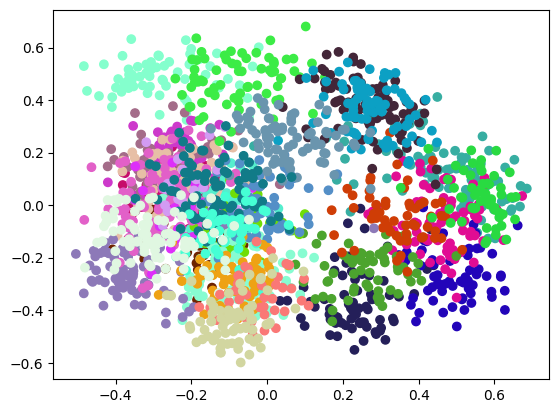

In [24]:
# Use PCA to reduce the dimensionality of the embeddings
pca = PCA(n_components=5)
embeddings_2d = pca.fit_transform(X_train)

# Map numeric labels to actual names
mapped_labels = [idx_to_class[label] for label in y_train]

# Define a function to assign colors to labels
def assign_colors(label):
    colors = {'Jessica Alba' : '#432638',
'Margot Robbie' : '#29da41',
'Hrithik Roshan' : '#8d79b8',
'Courtney Cox' : '#4ca42e',
'Akshay Kumar' : '#6e2400',
'Dwayne Johnson' : '#55eece',
'Tom Cruise' : '#45ffd5',
'Alia Bhatt' : '#84ffcd',
'Amitabh Bachchan' : '#c60c6a',
'Hugh Jackman' : '#e260c8',
'Robert Downey Jr' : '#117b88',
'Anushka Sharma' : '#a46c89',
'Natalie Portman' : '#0ca0c4',
'Charlize Theron' : '#2204b9',
'Andy Samberg' : '#cd39cb',
'Henry Cavill' : '#87fcd1',
'Marmik' : '#d29bf3',
'Camila Cabello' : '#3cec46',
'Ellen Degeneres' : '#6fdd06',
'Billie Eilish' : '#37aea2',
'Virat Kohli' : '#fa7876',
'Vijay Deverakonda' : '#e0f7e1',
'Alexandra Daddario' : '#241f59',
'Kashyap' : '#dd2ff9',
'Claire Holt' : '#e10c93',
'Zac Efron' : '#d2d6a0',
'Elizabeth Olsen' : '#cf3d06',
'Priyanka Chopra' : '#6a95ae',
'Brad Pitt' : '#e7bfa6',
'Lisa Kudrow' : '#548fc7',
'Roger Federer' : '#eea214'}
    return colors[label]

# Create color array for all points
colors = list(map(assign_colors, mapped_labels))

# Plot the 2D embeddings
plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=colors)
plt.show()

## Face Recognition

The code performs face recognition on randomly selected images from the validation set. It predicts the labels for the images and displays the predicted and actual labels along with the image:

[[0.00307232 0.00500896 0.00743224 0.00288459 0.00800856 0.01010556
  0.01568118 0.00641033 0.82276197 0.00242918 0.00609363 0.0076951
  0.00377119 0.00791028 0.0023302  0.00919734 0.00899487 0.0053582
  0.00907943 0.00816531 0.00247293 0.0035943  0.00316294 0.00349866
  0.00699496 0.01023986 0.00335505 0.00208814 0.00473388 0.00326257
  0.00420629]]


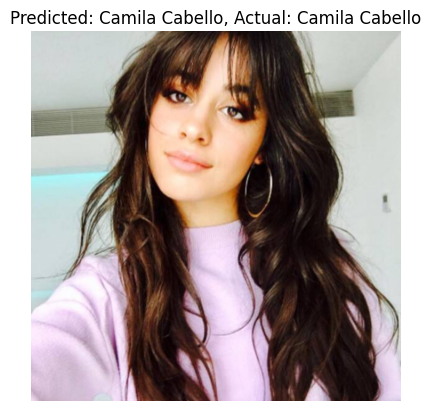

[[0.00605406 0.00384429 0.00536922 0.00460428 0.79362946 0.01460513
  0.00319888 0.00897326 0.00829528 0.00223167 0.00471034 0.00798962
  0.00350301 0.00396547 0.00349255 0.01739947 0.01076503 0.01903453
  0.00468691 0.00844497 0.00296072 0.00239889 0.00448879 0.00475551
  0.00351922 0.01138898 0.01055065 0.01403039 0.00232463 0.00287319
  0.0059116 ]]


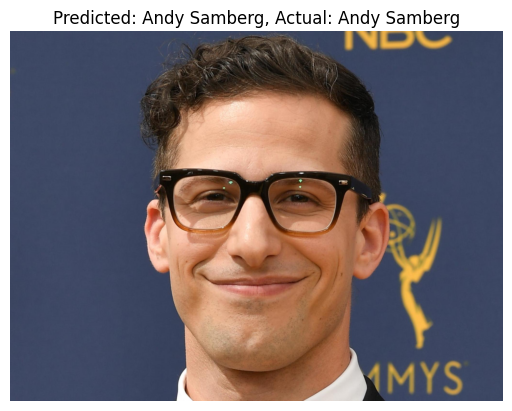

[[0.00523299 0.00311894 0.00702247 0.00290685 0.00930571 0.00301257
  0.00570483 0.83481355 0.0074701  0.00231255 0.00789234 0.0029422
  0.00282161 0.00434109 0.00318445 0.01307765 0.00962556 0.01158455
  0.00502597 0.00287309 0.00170074 0.00329807 0.00510613 0.00573253
  0.00276088 0.01715857 0.00257467 0.00490531 0.00555705 0.00296058
  0.0039764 ]]


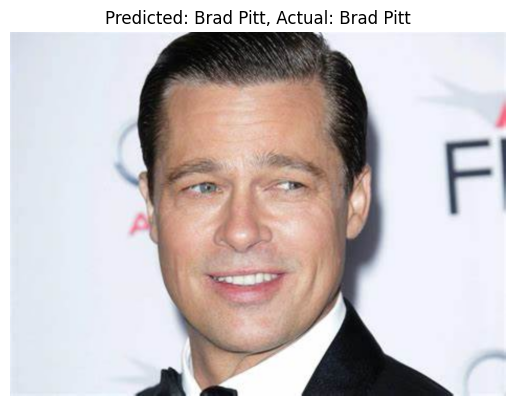

[[3.26686826e-03 4.19532201e-03 8.86797519e-04 1.11609587e-03
  2.89053312e-03 1.32741069e-03 2.28677394e-03 3.92838142e-03
  1.79148632e-03 1.78780165e-03 2.27724806e-03 4.55038767e-03
  1.60821606e-03 2.50220503e-03 9.01610402e-04 9.20172333e-01
  5.90270756e-03 3.97867319e-03 1.63221082e-03 1.57106519e-03
  6.93688735e-04 1.67360361e-03 8.78102011e-04 1.20806481e-03
  1.11672949e-03 2.96162117e-03 5.84703709e-03 5.79027917e-03
  1.74209823e-03 9.67589923e-04 8.54705843e-03]]


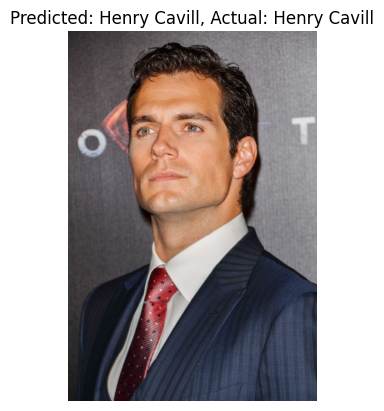

[[0.0031349  0.00315016 0.00129628 0.00151278 0.00823174 0.00258467
  0.00498563 0.00370421 0.0057748  0.00220212 0.00309371 0.00516705
  0.00175098 0.00367597 0.00121511 0.89050351 0.00640764 0.00484381
  0.00350877 0.00229049 0.0016861  0.00250871 0.00094217 0.00329575
  0.00142045 0.00767674 0.00541853 0.00489419 0.00271841 0.00138909
  0.00901554]]


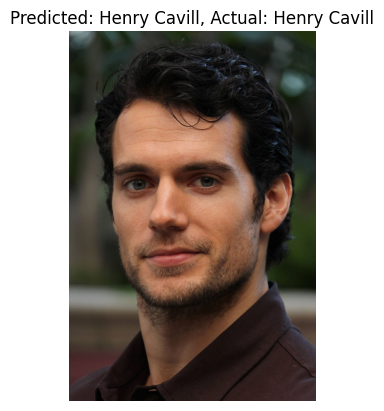

In [26]:

transform_img = transforms.Compose([transforms.Resize(1024)])
transform = transforms.Compose([
        transforms.Resize(1024),
        transforms.ToTensor()
    ])



dataset_val = datasets.ImageFolder(root="/content/val")
val_samples = dataset_val.samples


random_samples = random.choices(val_samples, k=5)

for img_path, true_label in random_samples:

    img_ = transform_img(Image.open(img_path).convert('RGB'))
    img = transform(Image.open(img_path).convert('RGB'))

    # Extract features
    _, embedding = extract_features(mtcnn, facenet, img)
    if embedding is None:
        print("Could not find face on {}".format(img_path))
        continue
    if embedding.shape[0] > 1:
        print("Multiple faces detected for {}, taking one with highest probability".format(img_path))
        embedding = embedding[0, :]


    predicted_label = clf.predict(embedding.reshape(1, -1))
    print(clf.predict_proba(embedding))

    predicted_class = idx_to_class[predicted_label[0]]
    true_class = idx_to_class[true_label]

    plt.imshow(img_)
    plt.title(f'Predicted: {predicted_class}, Actual: {true_class}')
    plt.axis('off')
    plt.show()


## Intruder Recognition

The code performs face recognition on a single image specified by img_path and displays the predicted label along with the image:

[[0.01235451 0.00670755 0.0047051  0.00496738 0.01392647 0.00367338
  0.0062506  0.01472291 0.00497246 0.00467946 0.01173205 0.00456885
  0.00223687 0.00544429 0.00284027 0.01871713 0.01319751 0.00603947
  0.00829373 0.00760278 0.00262376 0.00440191 0.00439594 0.00485215
  0.00401676 0.0085065  0.00666589 0.7920085  0.00389013 0.00303236
  0.00797332]]


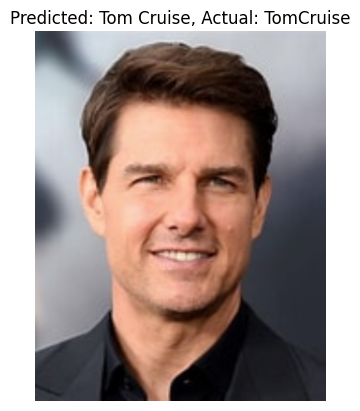

In [28]:
img_path = '/content/th.jpg'

img_ = transform_img(Image.open(img_path).convert('RGB'))
img = transform(Image.open(img_path).convert('RGB'))
_, embedding = extract_features(mtcnn, facenet, img)

predicted_label = clf.predict(embedding.reshape(1, -1))
# Convert label indexes back to original classes
predicted_class = idx_to_class[predicted_label[0]]
true_class = idx_to_class[true_label]
print((clf.predict_proba(embedding)))
thres = 0.6
if np.max(clf.predict_proba(embedding)) < thres:
    predicted_class = 'Intruder'


plt.imshow(img_)
plt.title(f'Predicted: {predicted_class}, Actual: {"TomCruise"}')
plt.axis('off')
plt.show()

[[0.01235451 0.00670755 0.0047051  0.00496738 0.01392647 0.00367338
  0.0062506  0.01472291 0.00497246 0.00467946 0.01173205 0.00456885
  0.00223687 0.00544429 0.00284027 0.01871713 0.01319751 0.00603947
  0.00829373 0.00760278 0.00262376 0.00440191 0.00439594 0.00485215
  0.00401676 0.0085065  0.00666589 0.7920085  0.00389013 0.00303236
  0.00797332]]


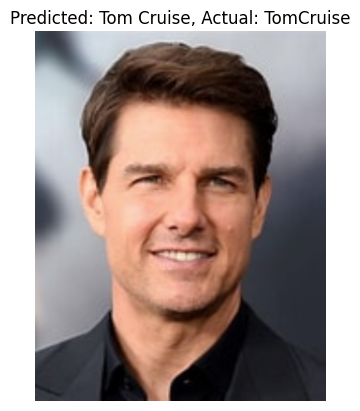

In [30]:
import joblib
import numpy as np
# Load the trained model
clf1 = joblib.load('face_recognition_model.pkl')


img_path = '/content/th.jpg'

img_ = transform_img(Image.open(img_path).convert('RGB'))
img = transform(Image.open(img_path).convert('RGB'))
_, embedding = extract_features(mtcnn, facenet, img)

predicted_label = clf1.predict(embedding.reshape(1, -1))
# Convert label indexes back to original classes
predicted_class = idx_to_class[predicted_label[0]]
true_class = idx_to_class[true_label]
print((clf1.predict_proba(embedding)))
thres = 0.6
if np.max(clf1.predict_proba(embedding)) < thres:
    predicted_class = 'Intruder'


plt.imshow(img_)
plt.title(f'Predicted: {predicted_class}, Actual: {"TomCruise"}')
plt.axis('off')
plt.show()